# #1 Importing the Data

In [257]:
import math
import pandas as pd
import numpy as np
from scipy.stats import iqr
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

main_disease_df = pd.read_csv('/Users/raph/Desktop/csci113/files/kidney_disease.csv')
main_disease_df.classification.unique()
main_disease_df.classification.loc[(main_disease_df.classification == 'ckd\t')] = 'ckd'
main_disease_df.classification.unique()

array(['ckd', 'notckd'], dtype=object)

# #2 Ways to Impute the Given Data

1. Upon seeing the data, it is noted that the data focuses heavily on patients. From this, the first method of imputation that can be proposed is a mixed of categorizing the data and applying an arbitary value to missing values. This can be done by categorizing or grouping them into desired groups e.g. age, blood pressure, diabetic, and etc. This is followed by applying central limit tendencies such as solving for the mean, median, or mode of said groups.

2. Another method of imputation is using the frequency of categorical values. This can be done by taking the mode of a certain column in the chosen dataframe. If a significant amount of the data seems to gravitate towards 1 categorical value with a few extremeties. It can be assumed that any NaN values present can be assumed to be the majority of the data. 

3. Another method to impute data is to use existing data to fill in possible gaps. This is especially useful in categorical data as taking the ratios of the event happening to the total number events can show a possible connection. This is similar to an if-then statement in mathematics where $a$ implies $b$. 

# #3 Removing rows where any NaN values exist.

In [258]:
# Focusing on the features "age", "bp", "sg", "al", and "sg"
main_df_rv = main_disease_df.iloc[:,[1,2,3,4,5,25]]
main_df_rv.dropna(inplace = True)
main_df_rv.to_csv("kidney_dataset_remove.csv")
main_df_rv

,age,bp,sg,al,su,classification
0,48.0,80.0,1.020,1.0,0.0,ckd
1,7.0,50.0,1.020,4.0,0.0,ckd
2,62.0,80.0,1.010,2.0,3.0,ckd
3,48.0,70.0,1.005,4.0,0.0,ckd
4,51.0,80.0,1.010,2.0,0.0,ckd
...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,notckd
396,42.0,70.0,1.025,0.0,0.0,notckd
397,12.0,80.0,1.020,0.0,0.0,notckd
398,17.0,60.0,1.025,0.0,0.0,notckd


# #4: Imputing the Data to Fill NaN Columns

### #4a
 We want to impute the blood pressure of the data (bp). This will be done by applying a binning method by grouping a range of ages into separate bins. Afterwards we can take the average of that range and impute it to those entries where the age column is not missing. Afterwards, we can filter out the disease dataframe to the respective bins and take the averages of the blood pressure as follows:



In [259]:
print('The number of NaN values under the column \'age\' before imputation : {}.'.format(main_disease_df.age.isna().sum())) 
print('The number of NaN values under the column \'bp\' before imputation : {}.'.format(main_disease_df.bp.isna().sum()))

The number of NaN values under the column 'age' before imputation : 9.
The number of NaN values under the column 'bp' before imputation : 12.


In [260]:
def freedman_diaconis(vals):
    return 2 * (iqr(vals) / (len(vals) ** (1./3)))

def FD_binning(main_df, variable_1):
    df = main_df.dropna(subset = [variable_1], how = 'all')
    adj_df = df[variable_1]
    def freedman_diaconis(vals):
        return 2 * (iqr(vals) / (len(vals) ** (1./3)))
    bin_width = freedman_diaconis(adj_df)
    num_bins = int((np.max(adj_df) + bin_width) / bin_width)
    var_1_bins = np.zeros((num_bins + 1, 1))
    var_1_lim = 0
    for i in range(num_bins+1):
        var_1_bins[i] = var_1_lim
        var_1_lim = np.floor(var_1_lim + bin_width)
    return bin_width, num_bins, var_1_bins



def avg_imputing(main_df, variable_1, variable_2, var_1_bins, num_bins):
    var_2_avg = np.zeros((num_bins-1,1))
    df = main_df.dropna(subset = [variable_1], how = 'all')
    for i in  range(num_bins-1):
        temp_df = df[(df[variable_1] > var_1_bins[i,:][0]) & (df[variable_1] <= var_1_bins[i+1,:][0])] 
        var_2_avg[i] = temp_df[variable_2].mean()
    
    for entry in range(len(main_df)):
        if math.isnan(main_df[variable_2][entry]) == True and math.isnan(main_df[variable_1][entry]) == False:
            for i in range(len(var_1_bins)-2):
                if main_df[variable_1][entry] > var_1_bins[i] and main_df[variable_1][entry] <= var_1_bins[i+1]:
                    main_df[variable_2][entry] = var_2_avg[i]
    return main_df
    

bin_width_age, num_bins_age, age_bins = FD_binning(main_disease_df, 'age')
main_disease_df = avg_imputing(main_disease_df, 'age', 'bp', age_bins, num_bins_age)

print('The number of NaN values in the column \'bp\' is {}'.format(main_disease_df.bp.isna().sum()))


The number of NaN values in the column 'bp' is 0


A similar method can be used to imputing the values under the age column. As we can assign the age based on the average blood pressure of the person.


In [261]:
bin_width_bp, num_bins_bp, bp_bins = FD_binning(main_disease_df, 'bp')
main_disease_df = avg_imputing(main_disease_df, 'bp', 'age', bp_bins, num_bins_bp)
print('The number of NaN values in the column \'age\' is {}'.format(main_disease_df.age.isna().sum()))

The number of NaN values in the column 'age' is 0


Since blood pressure is used in estimating specific gravity. We can applying a similar method of imputation as used in the previous section to obtain the NaN values of some patients

In [262]:
bin_width_bp, num_bins_bp, bp_bins = FD_binning(main_disease_df, 'bp')
main_disease_df = avg_imputing(main_disease_df, 'bp', 'sg', bp_bins, num_bins_bp)
print('The number of NaN values in the column \'sg\' is {}'.format(main_disease_df.sg.isna().sum()))


The number of NaN values in the column 'sg' is 3


## #4b
Another imputation that can be done is on the columns 'pc' and 'pcc'. Since 'pcc' is pus cell clumps. Something that can be noted would be ratio of between the number of patients who are abnormal under 'pc', yet have 'pcc' as notpresent. The percentages will be taken for this to better understand the

In [263]:
print('The number of patients who have \'abnormal\' pc and \'notpresent\' pcc: {}.'.format(len(main_disease_df[(main_disease_df.pcc == 'notpresent') & (main_disease_df.pc == 'abnormal')])))
print('The number of patients who have \'abnormal\' pc and \'present\' pcc: {}.'.format(len(main_disease_df[(main_disease_df.pcc == 'present') & (main_disease_df.pc == 'abnormal')])))
print('The number of patients who have \'normal\' pc and \'notpresent\' pcc: {}.'.format(len(main_disease_df[(main_disease_df.pcc == 'notpresent') & (main_disease_df.pc == 'normal')])))
print('The number of patients who have \'normal\' pc and \'present\' pcc: {}.'.format(len(main_disease_df[(main_disease_df.pcc == 'present') & (main_disease_df.pc == 'normal')])))


The number of patients who have 'abnormal' pc and 'notpresent' pcc: 43.
The number of patients who have 'abnormal' pc and 'present' pcc: 33.
The number of patients who have 'normal' pc and 'notpresent' pcc: 248.
The number of patients who have 'normal' pc and 'present' pcc: 8.


As seen from the data, we can assume that if a person has 'normal' pc then they will more likely to be 'notpresent' under pcc (about 98%). On the other hand, almost 43.5% (43.34%) of the 'abnormal' pc group has a chance of having pcc as 'present'. To imputate the data , we can assume that any missing values that have 'normal' under pc can be considered as 'notpresent' for pcc. For the 'abnormal' group, since over 50% would have pcc as 'present'. It may be assumed that the presenece of pcc is true for the 'abnormal' group. This is can also be applied the other way where the pcc can indicate the whether a person may or may not have a normal pc. First, we will be transforming the data into binary data where 1 is abnormal and 0 is normal while 1 is present and 0 is notpresent. 

In [264]:
bi_array = np.zeros((len(main_disease_df),2))
for entry in range(len(main_disease_df)):
    if main_disease_df.pc[entry] == 'normal':
        bi_array[entry,0] = 0
    elif main_disease_df.pc[entry] == 'abnormal':
        bi_array[entry,0] = 1
    else:
        bi_array[entry,0] = np.nan
    if main_disease_df.pcc[entry] == 'present':
        bi_array[entry,1] = 1
    elif main_disease_df.pcc[entry] == 'notpresent':
        bi_array[entry,1] = 0
    else:
        bi_array[entry,1] =  np.nan

bi_df = pd.DataFrame(bi_array, columns = ['bi_pc','bi_pcc'])
main_disease_df = pd.merge(main_disease_df,bi_df, left_index = True, right_index = True)
main_disease_df



,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,rc,htn,dm,cad,appet,pe,ane,classification,bi_pc,bi_pcc
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,5.2,yes,yes,no,good,no,no,ckd,0.0,0.0
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,NaN,no,no,no,good,no,no,ckd,0.0,0.0
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,NaN,no,yes,no,poor,no,yes,ckd,0.0,0.0
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,3.9,yes,no,no,poor,yes,yes,ckd,1.0,1.0
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,4.6,no,no,no,good,no,no,ckd,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,4.9,no,no,no,good,no,no,notckd,0.0,0.0
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,6.2,no,no,no,good,no,no,notckd,0.0,0.0
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,5.4,no,no,no,good,no,no,notckd,0.0,0.0
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,5.9,no,no,no,good,no,no,notckd,0.0,0.0


In [265]:
for entry in range(len(main_disease_df)):
    if main_disease_df.bi_pc[entry] == 0 and  math.isnan(main_disease_df.bi_pcc[entry]) == True:
        main_disease_df.bi_pcc[entry] = 0
    elif main_disease_df.bi_pc[entry] == 1 and math.isnan(main_disease_df.bi_pcc[entry]) == True:
        main_disease_df.bi_pcc[entry] = 1
        
for entry in range(len(main_disease_df)):
    if main_disease_df.bi_pcc[entry] == 0 and math.isnan(main_disease_df.bi_pc[entry]) == True:
        main_disease_df.bi_pc[entry] = 0
    elif main_disease_df.bi_pcc[entry] == 1 and math.isnan(main_disease_df.bi_pc[entry]) == True:
        main_disease_df.bi_pc[entry] = 1


In [266]:
print('The number of NaN values in the column \'bi_pc\': {}.' .format(main_disease_df.bi_pcc.isna().sum()))
print('The number of NaN values in the column \'bi_pcc\': {}.' .format(main_disease_df.bi_pcc.isna().sum()))

main_disease_df[main_disease_df.bi_pcc.isna()]

The number of NaN values in the column 'bi_pc': 1.
The number of NaN values in the column 'bi_pcc': 1.


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,rc,htn,dm,cad,appet,pe,ane,classification,bi_pc,bi_pcc
290,290,54.0,70.0,1.02,0.0,0.0,NaN,NaN,NaN,NaN,...,5.9,no,no,no,good,no,no,notckd,NaN,NaN


# #4c
Another imputation that can be done is on the bacteria column, 'ba'. Given that only 1% of the data is missing applying the central tendency of the mode would be useful. 

In [267]:
print('The number of NaN values in the column \'ba\': {}.'.format(main_disease_df.ba.isna().sum()))

print(main_disease_df.ba.groupby(main_disease_df.ba).count())
main_disease_df.ba.fillna('notpresent', inplace = True)
print('The number of NaN values in the column \'ba\' after imputation: {}.'.format(main_disease_df.ba.isna().sum()))

The number of NaN values in the column 'ba': 4.
ba
notpresent    374
present        22
Name: ba, dtype: int64
The number of NaN values in the column 'ba' after imputation: 0.


Similarly, the same imputation method can also be applied on the 'al' column as it can be noticed that majority of the data gravitates to one value with some outliers as seen below.

In [268]:
print('The number of NaN values in the column \'al\': {}.'.format(main_disease_df.al.isna().sum()))

print(main_disease_df.al.groupby(main_disease_df.al).count())
main_disease_df.al.fillna(0.0, inplace = True)
print('The number of NaN values in the column \'al\' after imputation: {}.'.format(main_disease_df.al.isna().sum()))

The number of NaN values in the column 'al': 46.
al
0.0    199
1.0     44
2.0     43
3.0     43
4.0     24
5.0      1
Name: al, dtype: int64
The number of NaN values in the column 'al' after imputation: 0.


## #4d
Another method of impuation is similar with the pc and pcc entry. The data used will be the 'dm' and 'su'. By grouping the sugar column by categorizing them on whether they are diabetic or not then taking the average will help impute missing data. It is also noted that the 'dm' column has misplaced data and cleaning the data will help readjust the data.

In [269]:
main_disease_df.dm.unique()
main_disease_df.dm.loc[(main_disease_df.dm == '\tno')] = 'no'
main_disease_df.dm.loc[(main_disease_df.dm == '\tyes')] = 'yes'
main_disease_df.dm.loc[(main_disease_df.dm == ' yes') ] = 'yes'

mu_su = main_disease_df.su.groupby(main_disease_df.dm).mean()
print(mu_su)
main_disease_df.su[(main_disease_df.dm == 'yes') & (main_disease_df.su == np.nan) ] = mu_su[1]
main_disease_df.su[(main_disease_df.dm == 'no') & (main_disease_df.su == np.nan)] = mu_su[0]
print('The number of NaN values under the column \'su\' after imputation: {}.' .format(main_disease_df.su.isna().sum()))


dm
no     0.077551
yes    1.336538
Name: su, dtype: float64
The number of NaN values under the column 'su' after imputation: 49.


## #4e 
Creating the .csv file containing the imputed dataset

In [270]:
main_disease_df.to_csv('kidney_dataset_imputed.csv')

# #5
For features age, blood pressure, specific gravity, albumin and sugar, aside from
the number of data rows available, describe the difference between
kidney_dataset_remove vs kidney_dataset_imputed. Use existing tools to
demonstrate how the shape or distribution of the data was affected in relation to
its classification (ckd or notckd)


b) In the imputation technique/s you used, why do you think the technique was
appropriate for the given features?

In [271]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Data Visualizations on the Dataset where NaN Values are Removed

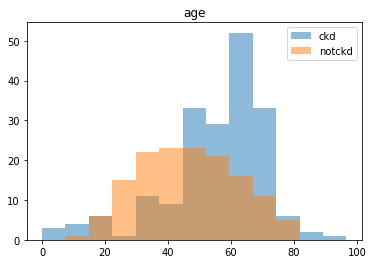

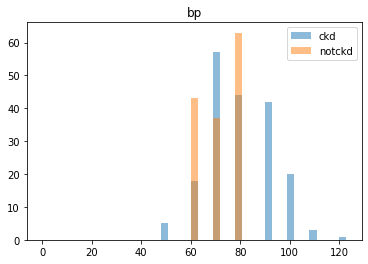

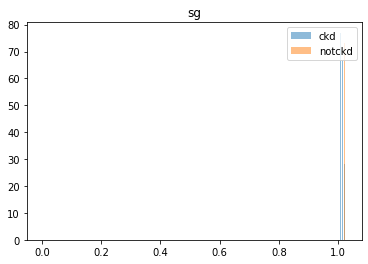

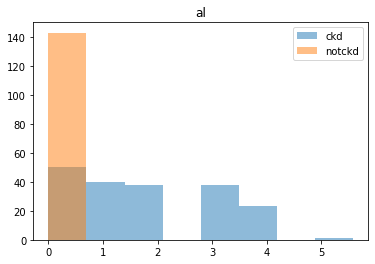

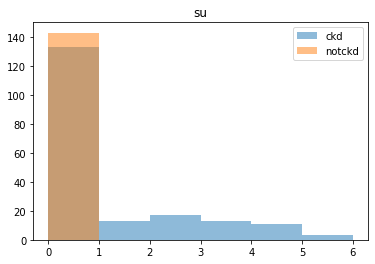

In [272]:
main_rv_ckd = main_df_rv[main_df_rv.classification == 'ckd']
main_rv_notckd = main_df_rv[main_df_rv.classification == 'notckd']


for i in range(len(main_df_rv.columns)-1):
    if i == 4:
        bins = [0, 1, 2, 3, 4, 5, 6]

    else:
        bin_width = freedman_diaconis(main_df_rv.iloc[:,i].values)
        num_bins = int((np.amax(main_df_rv.iloc[:,i].values) + bin_width) / bin_width)
        bins = np.linspace(0, np.amax(main_df_rv.iloc[:,i]) + bin_width, num_bins)
    plt.hist(main_rv_ckd.iloc[:,i].values, bins, alpha=0.5, label='ckd')
    plt.hist(main_rv_notckd.iloc[:,i].values, bins, alpha=0.5, label='notckd')
    plt.title(main_df_rv.columns[i])
    plt.legend(loc='upper right')
    plt.show()
        
        

<AxesSubplot:>

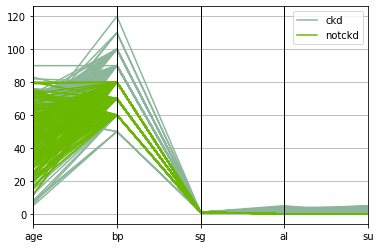

In [273]:
pd.plotting.parallel_coordinates(main_df_rv, 'classification')

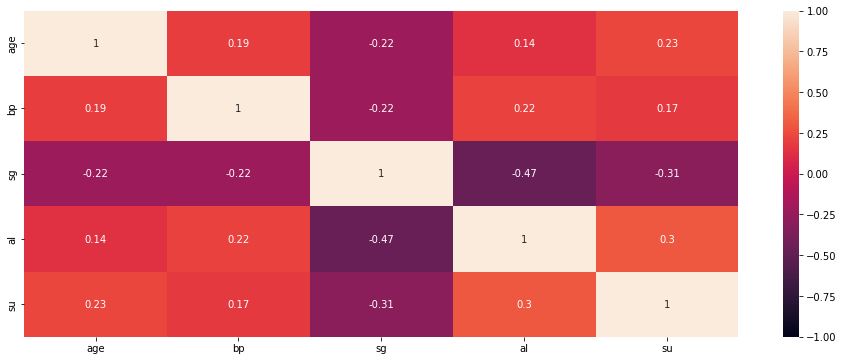

In [274]:
temp_rv = main_df_rv.drop(['classification'], axis=1)
corr_rv = temp_rv.corr()
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(corr_rv, vmin=-1, vmax=1, annot=True)

## Data Visualizations on the Dataset where NaN Values are Removed
Note: An some data values were also dropped specifically those in the 'al' columns as classifying it by age, blood pressure, or not classifying it at all may skew the data as I am not sure what factors affect the 'al' column.

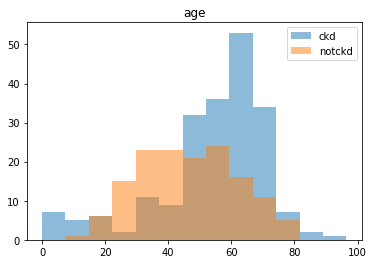

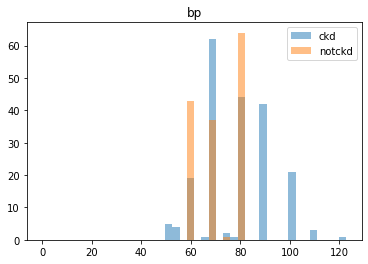

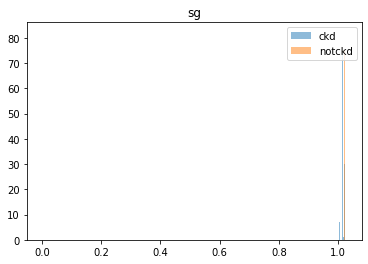

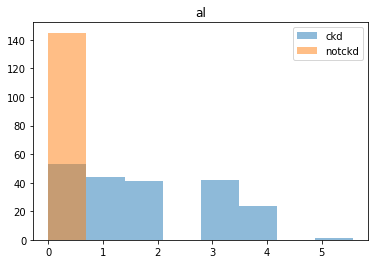

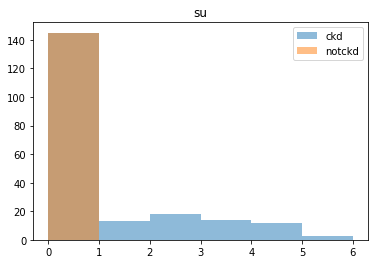

In [275]:
main_disease_imp = main_disease_df.iloc[:,[1,2,3,4,5,25]].dropna()

main_disease_ckd = main_disease_imp[main_disease_imp.classification == 'ckd']
main_disease_notckd = main_disease_imp[main_disease_imp.classification == 'notckd']


for i in range(len(main_disease_ckd.columns)-1):
    if i == 4:
        bins = [0, 1, 2, 3, 4, 5, 6]

    else:
        bin_width = freedman_diaconis(main_disease_imp.iloc[:,i].values)
        num_bins = int((np.amax(main_disease_imp.iloc[:,i].values) + bin_width) / bin_width)
        bins = np.linspace(0, np.amax(main_disease_imp.iloc[:,i]) + bin_width, num_bins)
    plt.hist(main_disease_ckd.iloc[:,i].values, bins, alpha=0.5, label='ckd')
    plt.hist(main_disease_notckd.iloc[:,i].values, bins, alpha=0.5, label='notckd')
    plt.title(main_disease_ckd.columns[i])
    plt.legend(loc='upper right')
    plt.show()
        
        

<AxesSubplot:>

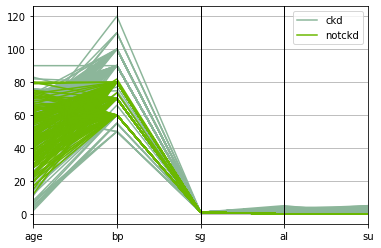

In [276]:
pd.plotting.parallel_coordinates(main_disease_imp, 'classification')

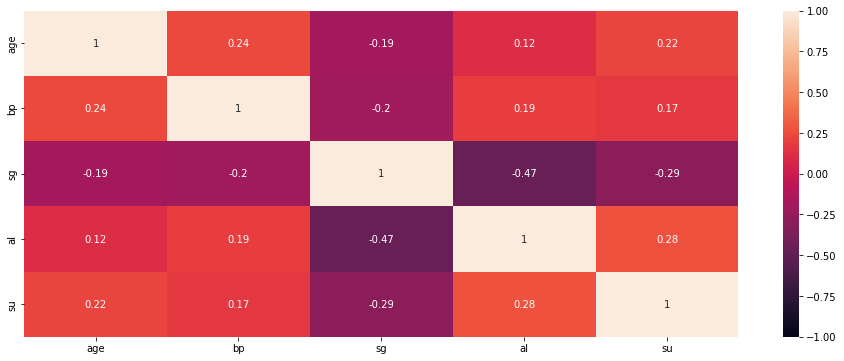

In [277]:
temp_imp = main_disease_imp.drop(['classification'], axis=1)
corr_imp = temp_imp.corr()
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(corr_imp, vmin=-1, vmax=1, annot=True)

## #5a
Dropping the NaN values compared to imputing these NaN values cause little no changes visually. This can be seen from the historgrams used to visualize the data except for the visualiztion of the sugar column, 'su', as taking the average of people who have diabetes was used to impute the data. Thus, showing that diabetes does not necessarily imply a high sugar level. Similarly, the parallet coordinates also show a similar visualization. However. the changes are more noticeable in the heat map containing the correlations of the data. More specifically, the correlation between the age and the blood pressure of an individual is more positively correlated at 0.24 compared to when dropping the NaN values which gives a correlation of 0.19. The correlation between age and albumin also dropped from 0.14 to 0.12 when imputing the data. To conclude, the imputation of the data might have not contributed a statistically significant change comparted to just dropping the NaN values. 

## #5b
Out of all the imputation techniques used in the imputed dataset, I believe that the age and the blood pressure column had used proper impuation techniques. This is because the age was factored in the blood pressure of an individual. It follows that taking the average after placing the individuals in the appropriate bins will give a proper average given an individual's age since the existence of extremeties will greatly shift the data. This method was also applied to age where I assumed that age and blood pressure are factored witl one another which can be seen in the heat map. For the specific gravity, a similar technique as the previous imputation on blood pressure and age was used. However, blood pressure may not be the only factor or main factor that affect specific gravity as the data from the dropped dataset did not greatly differ from the imputed dataset. Thus, the imputation method may not be the preferred one. The albumin was dropped as an imputation method since categorizing or failing to categorize may skew the data. Lastly, the sugar imputation used a categorical grouping followed by taking the average of the given groups. The method of imputation for this feature is appropriate as the data shows that sugar level does not necessarily matter when an individual is diabetic. 